##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pix2Pix

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates image to image translation using conditional GAN's, as described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, we convert building facades to real buildings.

In example, we will use the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/), helpfully provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep our example short, we will use a preprocessed [copy](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/) of this dataset, created by the authors of the [paper](https://arxiv.org/abs/1611.07004) above.

Each epoch takes around 15 seconds on a single V100 GPU.

Below is the output generated after training the model for 200 epochs.

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import os
import time
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time
import scipy.io as scio
from IPython import display

### 导入CT数据

In [2]:
CTdataFile1 = 'C:/Users/dell/Desktop/data/data_sub1_abdPelvis_dxCoord.mat'
CTdata1 = scio.loadmat(CTdataFile1)['CT'].transpose(2,0,1)

CTdataFile2 = 'C:/Users/dell/Desktop/data/data_sub2_abdPelvis_dxCoord.mat'
CTdata2 = scio.loadmat(CTdataFile2)['CT'].transpose(2,0,1)

CTdataFile4 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
CTdata4 = scio.loadmat(CTdataFile4)['CT'].transpose(2,0,1)

CTdataFile6 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
CTdata6 = scio.loadmat(CTdataFile6)['CT'].transpose(2,0,1)

CTdataFile7 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
CTdata7 = scio.loadmat(CTdataFile7)['CT'].transpose(2,0,1)

CTdataFile8 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
CTdata8 = scio.loadmat(CTdataFile8)['CT'].transpose(2,0,1)

CTdataFile13 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
CTdata13 = scio.loadmat(CTdataFile13)['CT'].transpose(2,0,1)

CTdataFile14 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
CTdata14 = scio.loadmat(CTdataFile14)['CT'].transpose(2,0,1)

CTdata = np.concatenate((CTdata1,CTdata2,CTdata4,CTdata6,CTdata7,CTdata8,CTdata13,CTdata14),axis=0)

### 导入MR数据

In [3]:
MRdataFile1 = 'C:/Users/dell/Desktop/data/data_sub1_abdPelvis_dxCoord.mat'
MRdata1 = scio.loadmat(MRdataFile1)['atMR'].transpose(2,0,1)

MRdataFile2 = 'C:/Users/dell/Desktop/data/data_sub2_abdPelvis_dxCoord.mat'
MRdata2 = scio.loadmat(MRdataFile2)['atMR'].transpose(2,0,1)

MRdataFile4 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
MRdata4 = scio.loadmat(MRdataFile4)['atMR'].transpose(2,0,1)

MRdataFile6 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
MRdata6 = scio.loadmat(MRdataFile6)['atMR'].transpose(2,0,1)

MRdataFile7 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
MRdata7 = scio.loadmat(MRdataFile7)['atMR'].transpose(2,0,1)

MRdataFile8 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
MRdata8 = scio.loadmat(MRdataFile8)['atMR'].transpose(2,0,1)

MRdataFile13 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
MRdata13 = scio.loadmat(MRdataFile13)['atMR'].transpose(2,0,1)

MRdataFile14 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
MRdata14 = scio.loadmat(MRdataFile14)['atMR'].transpose(2,0,1)

MRdata = np.concatenate((MRdata1,MRdata2,MRdata4,MRdata6,MRdata7,MRdata8,MRdata13,MRdata14),axis=0)

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
#归一化
MRdata = (MRdata - np.min(MRdata)) /(np.max(MRdata)-np.min(MRdata))
CTdata = (CTdata - np.min(CTdata)) /(np.max(CTdata)-np.min(CTdata))


In [5]:
input_data = np.concatenate((MRdata,CTdata),axis=2)

In [7]:
input_data.shape

(660, 512, 1024)

In [9]:
def load(image):

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [27]:
input_data[1,:,:,0].shape

(512, 1024)

In [25]:
input_data.shape
inp , re = load(input_data[1,:,:,0])
plt.figure()
plt.imshow(inp)
plt.figure()
plt.imshow(re)

IndexError: too many indices for array

In [14]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])
 
  return cropped_image[0], cropped_image[1]

In [15]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 572 x 572 x 1
  input_image, real_image = resize(input_image, real_image, 572, 572)

  # randomly cropping to 512 x 512 x 1
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

As you can see in the images below
that they are going through random jittering
Random jittering as described in the paper is to

1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip the image horizontally

In [ ]:
CTdata.dtype

In [16]:
def load_image_train(input_data):
  input_image, real_image = load(input_data)
  input_image, real_image = random_jitter(input_image, real_image)

  return input_image, real_image

In [17]:
def load_image_test(input_data):
  input_image, real_image = load(input_data)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)

  return input_image, real_image

In [18]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

## Input Pipeline

In [19]:
input_data = input_data.reshape(input_data.shape[0], 512, 1024, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(input_data)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [28]:
test_dataset = input_data[:100,:,:,:]
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [29]:
OUTPUT_CHANNELS = 1

In [30]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [31]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [32]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[512,512,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 256, 256, 64)
    downsample(128, 4), # (bs, 128, 128, 128)
    downsample(256, 4), # (bs, 64, 64, 256)
    downsample(512, 4), # (bs, 32, 32, 512)
    downsample(1024, 4), # (bs, 16, 16, 1024)
    downsample(1024, 4), # (bs, 8, 8, 512)
    downsample(1024, 4), # (bs, 4, 4, 1024)
    downsample(1024, 4), # (bs, 2, 2, 1024)
    downsample(1024, 4), # (bs, 1, 1, 1024)
  ]

  up_stack = [
    upsample(1024, 4, apply_dropout=True), # (bs, 2, 2, 2048)
    upsample(1024, 4, apply_dropout=True), # (bs, 4, 4, 2048)
    upsample(1024, 4, apply_dropout=True), # (bs, 8, 8, 2048)
    upsample(1024, 4), # (bs, 16, 16, 2048)
    upsample(512, 4), # (bs, 32, 32, 1024)
    upsample(256, 4), # (bs, 64, 64, 512)
    upsample(128, 4), # (bs, 128, 128, 256)
    upsample(64, 4), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 512, 512, 1)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [33]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [34]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 64) 1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 128, 128 131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 64, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [35]:
LAMBDA = 100

In [36]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [37]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[512, 512, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 512, 512, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 256, 256, 64)
  down2 = downsample(128, 4)(down1) # (bs, 128, 128, 128)
  down3 = downsample(256, 4)(down2) # (bs, 64, 64, 256)
  down4 = downsample(256, 4)(down3) # (bs, 32, 32, 256)
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [38]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)
discriminator.summary()

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 512, 512, 2)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequen

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [39]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)  

In [40]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [41]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [43]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i][:,:,0] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

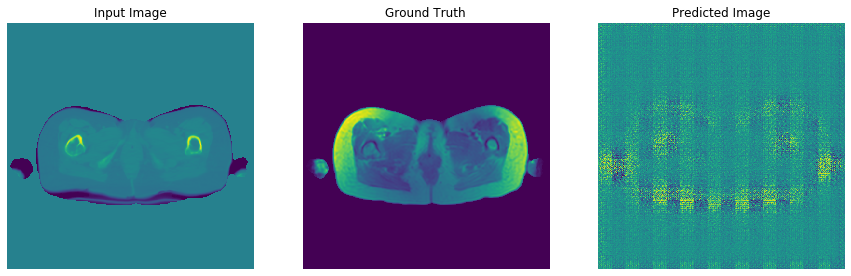

In [44]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [45]:
EPOCHS = 150

In [46]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [47]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [48]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [49]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 85344), started 3 days, 1:08:49 ago. (Use '!kill 85344' to kill it.)

Now run the training loop:

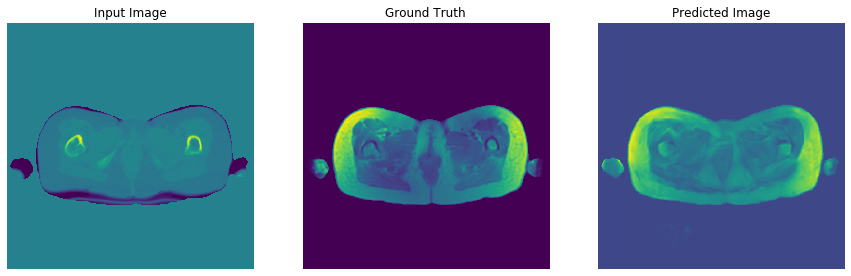

Epoch:  132
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................................................................

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-91e4b5f743cc>", line 1, in <module>
    fit(train_dataset, EPOCHS, test_dataset)
  File "<ipython-input-48-7bba0c4967a4>", line 16, in fit
    train_step(input_image, target, epoch)
  File "c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\eager\def_function.py", line 457, in __call__
    result = self._call(*args, **kwds)
  File "c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\eager\def_function.py", line 487, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\eager\function.py", line 1823, in __call__
    return g

KeyboardInterrupt: 

In [50]:
fit(train_dataset, EPOCHS, test_dataset)

If you want to share the TensorBoard results _publicly_ you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir  {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [51]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at foolding the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test

In [52]:
!ls {checkpoint_dir}

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [53]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

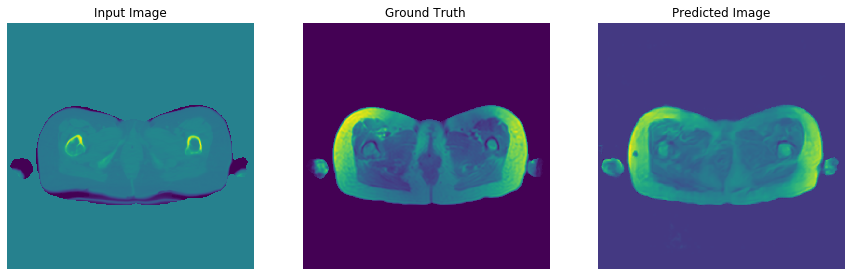

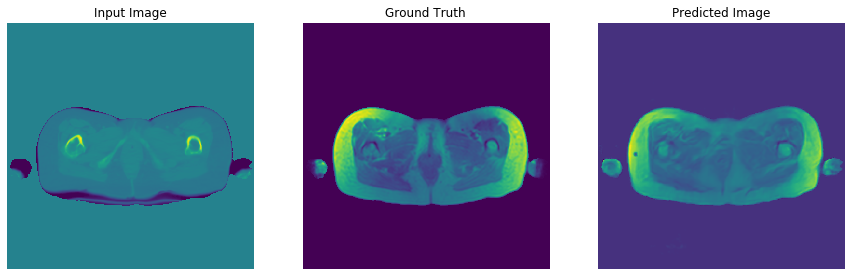

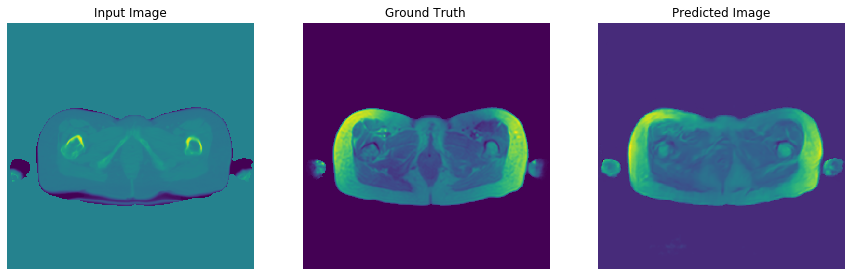

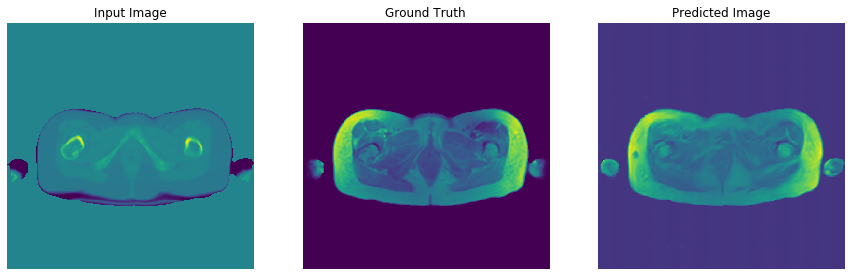

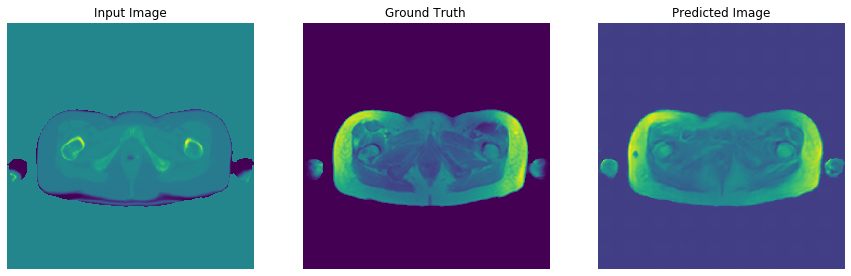

In [54]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)